# Predicción de géneros musicales 

### Índice
1. Introducción
2. Carga y limpieza
3. Visualización
4. Preprocesamiento
5. Entrenamiento
6. Evaluación
7. Análisis de características musicales

### 1.Introducción

En este cuaderno se utilizarán modelos para categorizar canciones según su género musical. Los géneros presentes en el dataset son 'Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Rap', 'Blues', 'Rock', 'Classical', 'Hip-Hop'. El objetivo principal de este cuaderno es identificar las características de audio que son más determinantes para predecir una canción como un género u otro.

El dataset puede ser obtenido en [este enlace](https://www.kaggle.com/datasets/vicsuperman/prediction-of-music-genre) y utiliza datos de la API de Spotify.

A continuación, se van a explicar las diferentes columnas del dataset.
- instance_id: ID de la instancia.
- artist_name: Nombre del artista.
- track_name: Nombre de la canción.
- popularity: Popularidad de la canción. El valor está en el rango 0-100, siendo 100 la más popular.
- acousticness: Confianza de 0 a 1 de que una canción sea acústica. Un 1 representa una alta confianza de que la canción sea acústica.
- danceability: Variable que mide de 0 a 1 cómo de bailable es una canción basándose en características como el tempo, la estabilidad del ritmo o la fuerza del beat.
- duration_ms: duración de la canción en milisegundos.
- energy: Medida de 0 a 1 que representa cómo de intensa se percibe una canción. Por ejemplo, una canción de Rock tendría mucha energía, y un preludio de Bach tendría poca energía. 
- instrumentalness: Variable que predice de 0 a 1 si una canción contiene voces. Las canciones de rap o palabras cantadas se consideran sonidos vocales, y onomatopeyas se consideran instrumentales. Mayores valores indican una mayor probabilidad de que una canción sea puramete instrumental.
- key: Escala musical en formato inglés. Por ejemplo: Do = C, Do♯/Re♭ = C♯/D♭, Re= D, 
- liveness: Medida de 0 a 1 que predice si la canción es en directo o no.
- loudness: Fuerza de la canción en decibelios (dB). Los valores típicos son entre -60 y 0 dB. 
- mode: Indica la modalidad (Mayor o menor) de una canción. Mayor se representa como 1 y menor como 0.
- speechiness: Medida de 0 a 1 que detecta la presencia de palabras habladas en la canción. Cuanto más cercana sea a un discurso (audiolibros, podcasts...) más cercano a 1 será el valor. Valores entre 0.33 y 0.66 indican que hay tanto música como discurso. Y valores por debajo de 0.33 representan más a música y otro tipo de contenido sin discursos.
- tempo: Velocidad estimada de una canción en beats por minuto (BPM).
- obtained_date: Fecha en la que se obtuvo la instancia de la API de Spotify.
- valence: Medida de 0 a 1 que indica la positividad que transmite una canción. Canciones con un valor alto transmiten sentimientos más positivos (felicidad, euforia...) y canciones con valor bajo transmiten sentimientos más negativos (tristeza, enfado...).
- music_genre: Género musical al que pertenece la canción. Los posibles valores son 'Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Rap', 'Blues', 'Rock', 'Classical', 'Hip-Hop'.

### 2. Carga y limpieza

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

In [54]:
music_df = pd.read_csv('music_genre.csv')
print(music_df.head())

   instance_id           artist_name            track_name  popularity  \
0      32894.0              Röyksopp  Röyksopp's Night Out        27.0   
1      46652.0  Thievery Corporation      The Shining Path        31.0   
2      30097.0        Dillon Francis             Hurricane        28.0   
3      62177.0              Dubloadz                 Nitro        34.0   
4      24907.0           What So Not      Divide & Conquer        32.0   

   acousticness  danceability  duration_ms  energy  instrumentalness key  \
0       0.00468         0.652         -1.0   0.941           0.79200  A#   
1       0.01270         0.622     218293.0   0.890           0.95000   D   
2       0.00306         0.620     215613.0   0.755           0.01180  G#   
3       0.02540         0.774     166875.0   0.700           0.00253  C#   
4       0.00465         0.638     222369.0   0.587           0.90900  F#   

   liveness  loudness   mode  speechiness               tempo obtained_date  \
0     0.115    -5.2

In [55]:
# Drop obtained_date column -> seems to be the date added to the dataset
music_df = music_df.drop('obtained_date', axis=1)

In [56]:
# Check target column shape
print(music_df['music_genre'].value_counts())

music_genre
Electronic     5000
Anime          5000
Jazz           5000
Alternative    5000
Country        5000
Rap            5000
Blues          5000
Rock           5000
Classical      5000
Hip-Hop        5000
Name: count, dtype: int64


Como se puede observar, la cantidad de canciones con cada género está equilibrada. Esto puede ayudarnos para evitar que haya géneros con mayor presencia en los datos, y por lo tanto esos géneros se vean beneficiados a la hora de la clasificación.

In [57]:
# Check column types read by pandas -> preprocessing needed before train and tempo column is object...
print(music_df.dtypes)

instance_id         float64
artist_name          object
track_name           object
popularity          float64
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
key                  object
liveness            float64
loudness            float64
mode                 object
speechiness         float64
tempo                object
valence             float64
music_genre          object
dtype: object


In [58]:
# Check for missing values
print(music_df.isnull().sum())

# Some missing values (5) in the dataset, drop them
music_df = music_df.dropna()

instance_id         5
artist_name         5
track_name          5
popularity          5
acousticness        5
danceability        5
duration_ms         5
energy              5
instrumentalness    5
key                 5
liveness            5
loudness            5
mode                5
speechiness         5
tempo               5
valence             5
music_genre         5
dtype: int64


In [59]:
# Check what happens with the tempo column --> should be float but is object
print(music_df['tempo'].head())

0               100.889
1    115.00200000000001
2               127.994
3               128.014
4               145.036
Name: tempo, dtype: object


In [60]:
# Check which values can and cannot be converted to float
conversions = {
    'can': [],
    'cannot': []
}
for i in music_df['tempo']:
    try:
        float(i)
        conversions['can'].append(i)
    except ValueError:
        conversions['cannot'].append(i)

print(len(conversions.get('cannot')))
print(np.unique(conversions.get('cannot')))

4980
['?']


In [61]:
# All non convertible values are '?', replace them with NaN --> later we will see how to handle them
music_df['tempo'] = music_df['tempo'].replace('?', np.nan)

# Convert tempo column to float
music_df['tempo'] = music_df['tempo'].astype(float)

print(music_df['tempo'].head())

0    100.889
1    115.002
2    127.994
3    128.014
4    145.036
Name: tempo, dtype: float64


In [62]:
# Describe the dataset
print(music_df.describe())

        instance_id    popularity  acousticness  danceability   duration_ms  \
count  50000.000000  50000.000000  50000.000000  50000.000000  5.000000e+04   
mean   55888.396360     44.220420      0.306383      0.558241  2.212526e+05   
std    20725.256253     15.542008      0.341340      0.178632  1.286720e+05   
min    20002.000000      0.000000      0.000000      0.059600 -1.000000e+00   
25%    37973.500000     34.000000      0.020000      0.442000  1.748000e+05   
50%    55913.500000     45.000000      0.144000      0.568000  2.192810e+05   
75%    73863.250000     56.000000      0.552000      0.687000  2.686122e+05   
max    91759.000000     99.000000      0.996000      0.986000  4.830606e+06   

             energy  instrumentalness      liveness      loudness  \
count  50000.000000      50000.000000  50000.000000  50000.000000   
mean       0.599755          0.181601      0.193896     -9.133761   
std        0.264559          0.325409      0.161637      6.162990   
min        0

In [63]:
# Now we can save the cleaned dataset to a new csv file
music_df.to_csv('cleaned_music_genre.csv', index=False)

### 3. Visualización

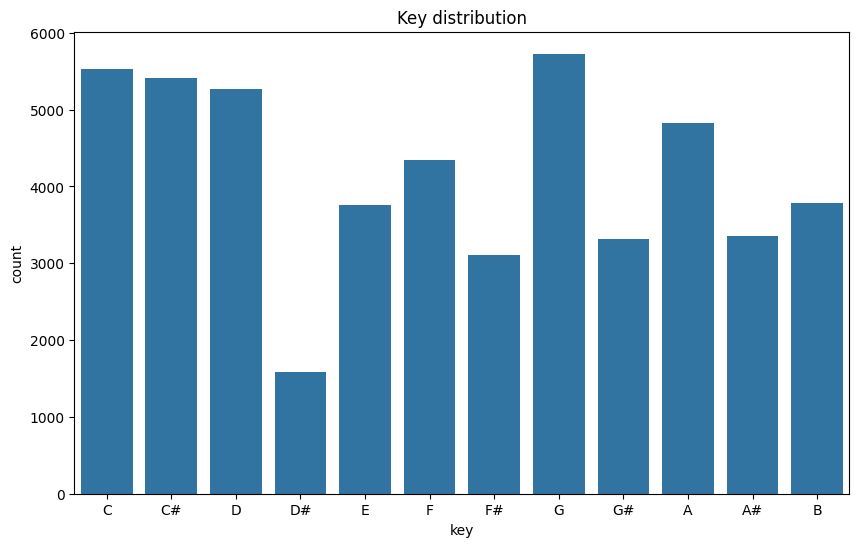

In [64]:
key_order = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

# One of the first things we want to visualize is the distribution of the key column, to see if it is relevant for the study
plt.figure(figsize=(10, 6))
sns.countplot(x='key', data=music_df, order=key_order)
plt.title('Key distribution')
plt.show()

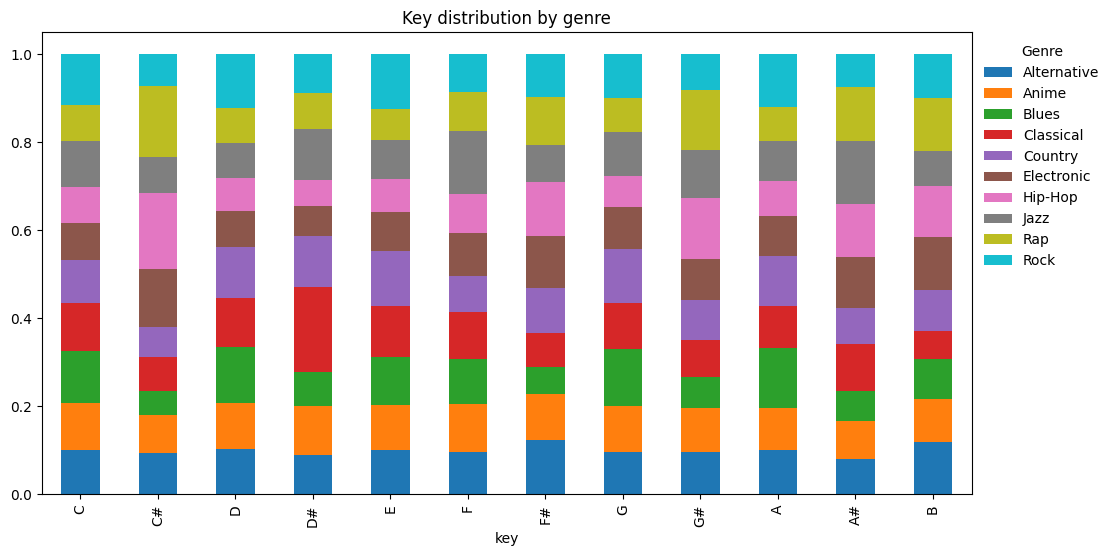

In [65]:
# Now we can visualize the distribution depending on the genre
key_genre_distribution = music_df.groupby('key')['music_genre'].value_counts(normalize=True).unstack()
key_genre_distribution = key_genre_distribution.reindex(key_order)
key_genre_distribution.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.legend(title='Genre', bbox_to_anchor=(1, 1), loc='upper left', frameon=False)
plt.title('Key distribution by genre')
plt.show()


In [66]:
# Chi-square test to check if key and genre are independent
key_genre_contingency_table = pd.crosstab(music_df['key'], music_df['music_genre'])

chi2, p, dof, expected = chi2_contingency(key_genre_contingency_table)

print(f"Chi-squared: {chi2}")
print(f"P-value: {p}")
if p < 0.05:
    print("Existe una relación significativa entre 'key' y 'music_genre'.")
else:
    print("No existe una relación significativa entre 'key' y 'music_genre'.")


Chi-squared: 2420.652503437906
P-value: 0.0
Existe una relación significativa entre 'key' y 'music_genre'.


In [67]:
def cramers_v(chi2, n, dof):
  return np.sqrt(chi2 / (n * min(dof, len(key_genre_contingency_table.columns) - 1)))

n = len(music_df)

cramers_v_value = cramers_v(chi2, n, dof)

print(f"Cramér's V: {cramers_v_value}")

Cramér's V: 0.07334321908273163


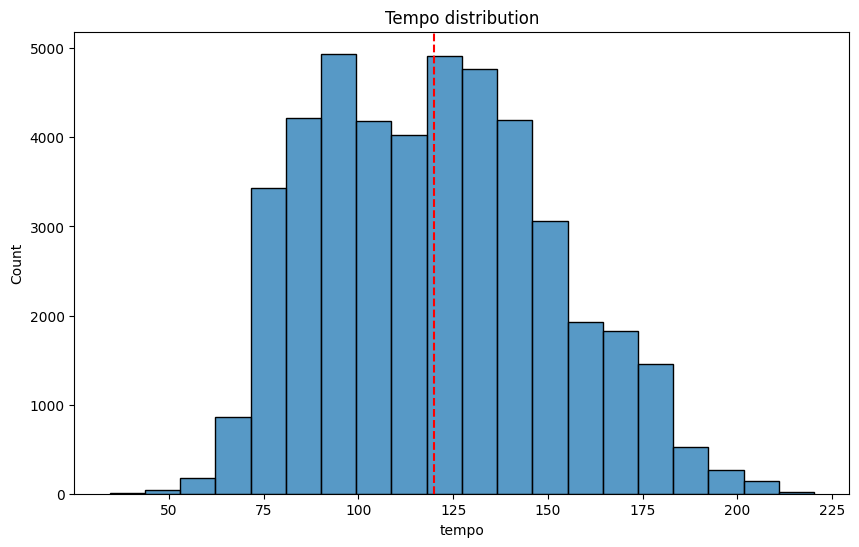

In [68]:
# Visualize the distribution of the tempo column
plt.figure(figsize=(10, 6))
sns.histplot(music_df['tempo'], bins=20)
plt.axvline(music_df['tempo'].mean(), color='red', linestyle='--', label='Mean')
plt.title('Tempo distribution')
plt.show()

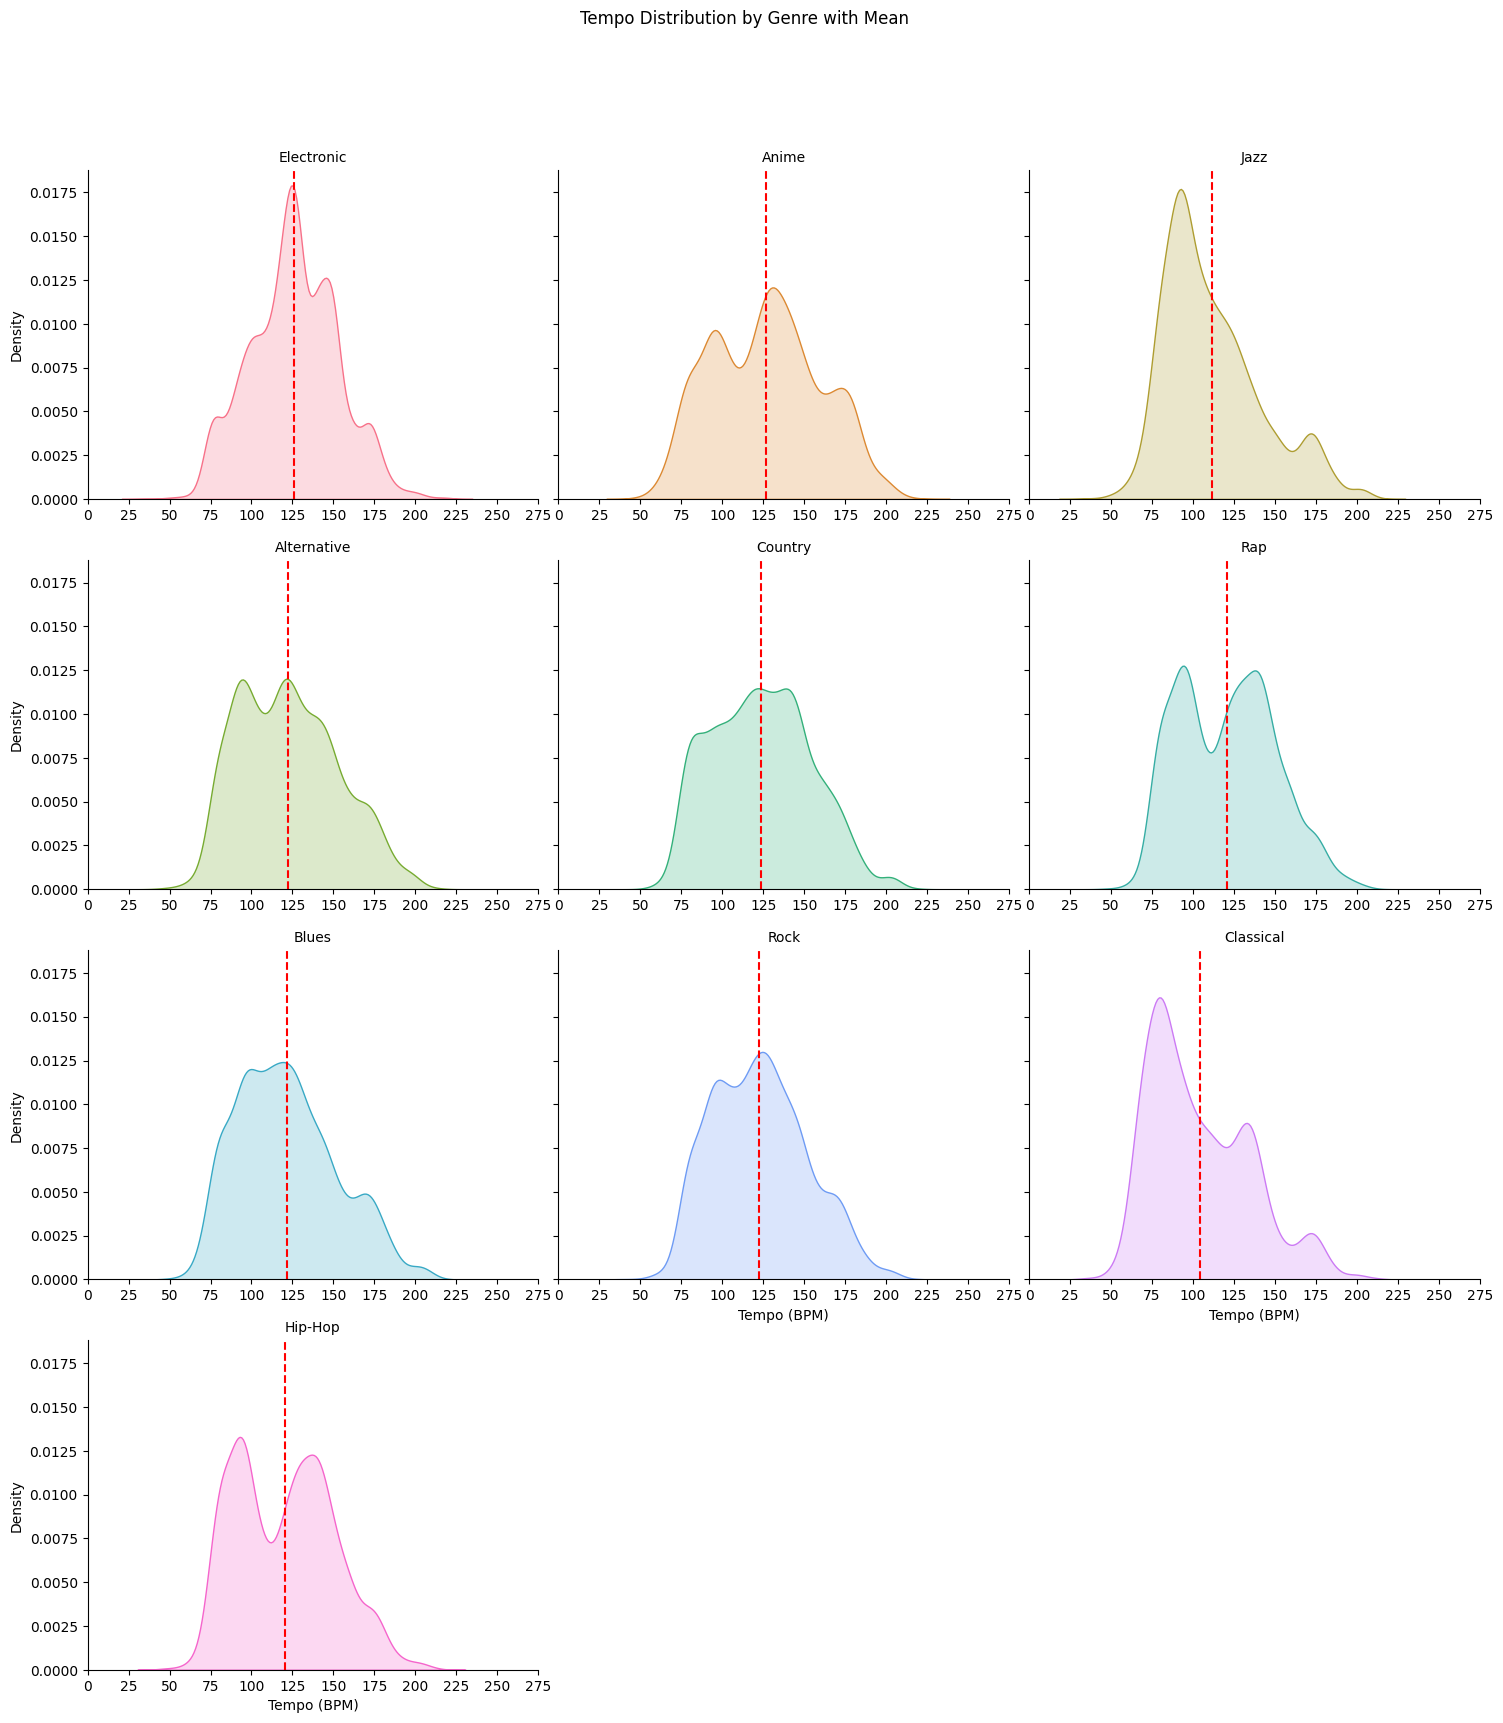

In [69]:
# Visualize the distribution of the tempo column depending on the genre
g = sns.FacetGrid(music_df, col="music_genre", col_wrap=3, height=5, sharex=False, sharey=True, hue="music_genre", palette="husl")


def add_kde_with_mean(data, **kwargs):
    sns.kdeplot(data=data, x="tempo", fill=True, **kwargs)
    plt.axvline(data["tempo"].mean(), color='red', linestyle='--', label='Mean')  

g.map_dataframe(add_kde_with_mean)

for ax in g.axes.flat:
  ax.set_xlim(0, 250)
  ax.set_xticks(range(0, 300, 25)) 

g.set_titles("{col_name}")
g.set_axis_labels("Tempo (BPM)", "Density")
plt.subplots_adjust(bottom=0.15, top=0.9) 
g.figure.suptitle('Tempo Distribution by Genre with Mean')
plt.show()

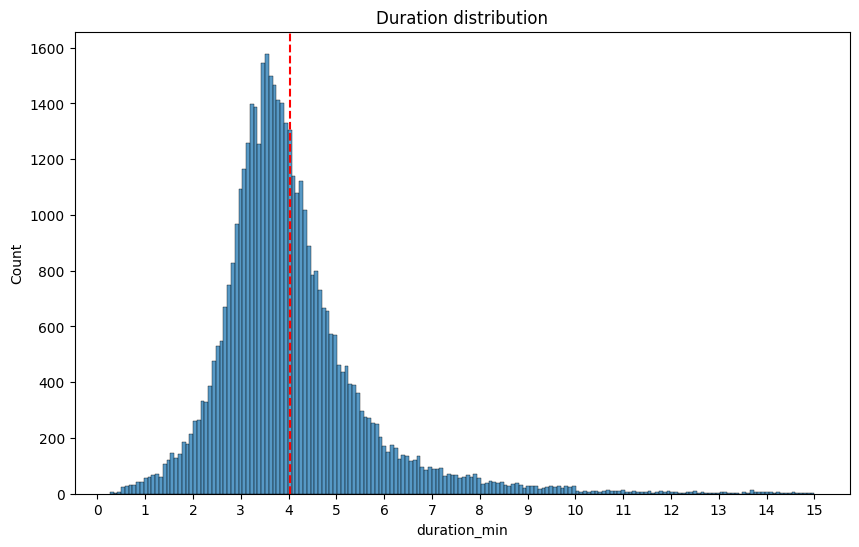

In [70]:
# Visualize durations distribution in minutes
duration_mins = music_df.copy()[['duration_ms', 'music_genre']]
duration_mins['duration_min'] = (duration_mins['duration_ms'] / 60000).round(2)

# Filter between 0 and 30 minutes
duration_mins['duration_min'] = duration_mins['duration_min'][(duration_mins['duration_min'] > 0) & (duration_mins['duration_min'] <=15)]

plt.figure(figsize=(10, 6))
sns.histplot(duration_mins['duration_min'])
plt.axvline(duration_mins['duration_min'].mean(), color='red', linestyle='--', label='Mean')
plt.title('Duration distribution')
plt.xticks(range(0, 16,1))
plt.show()


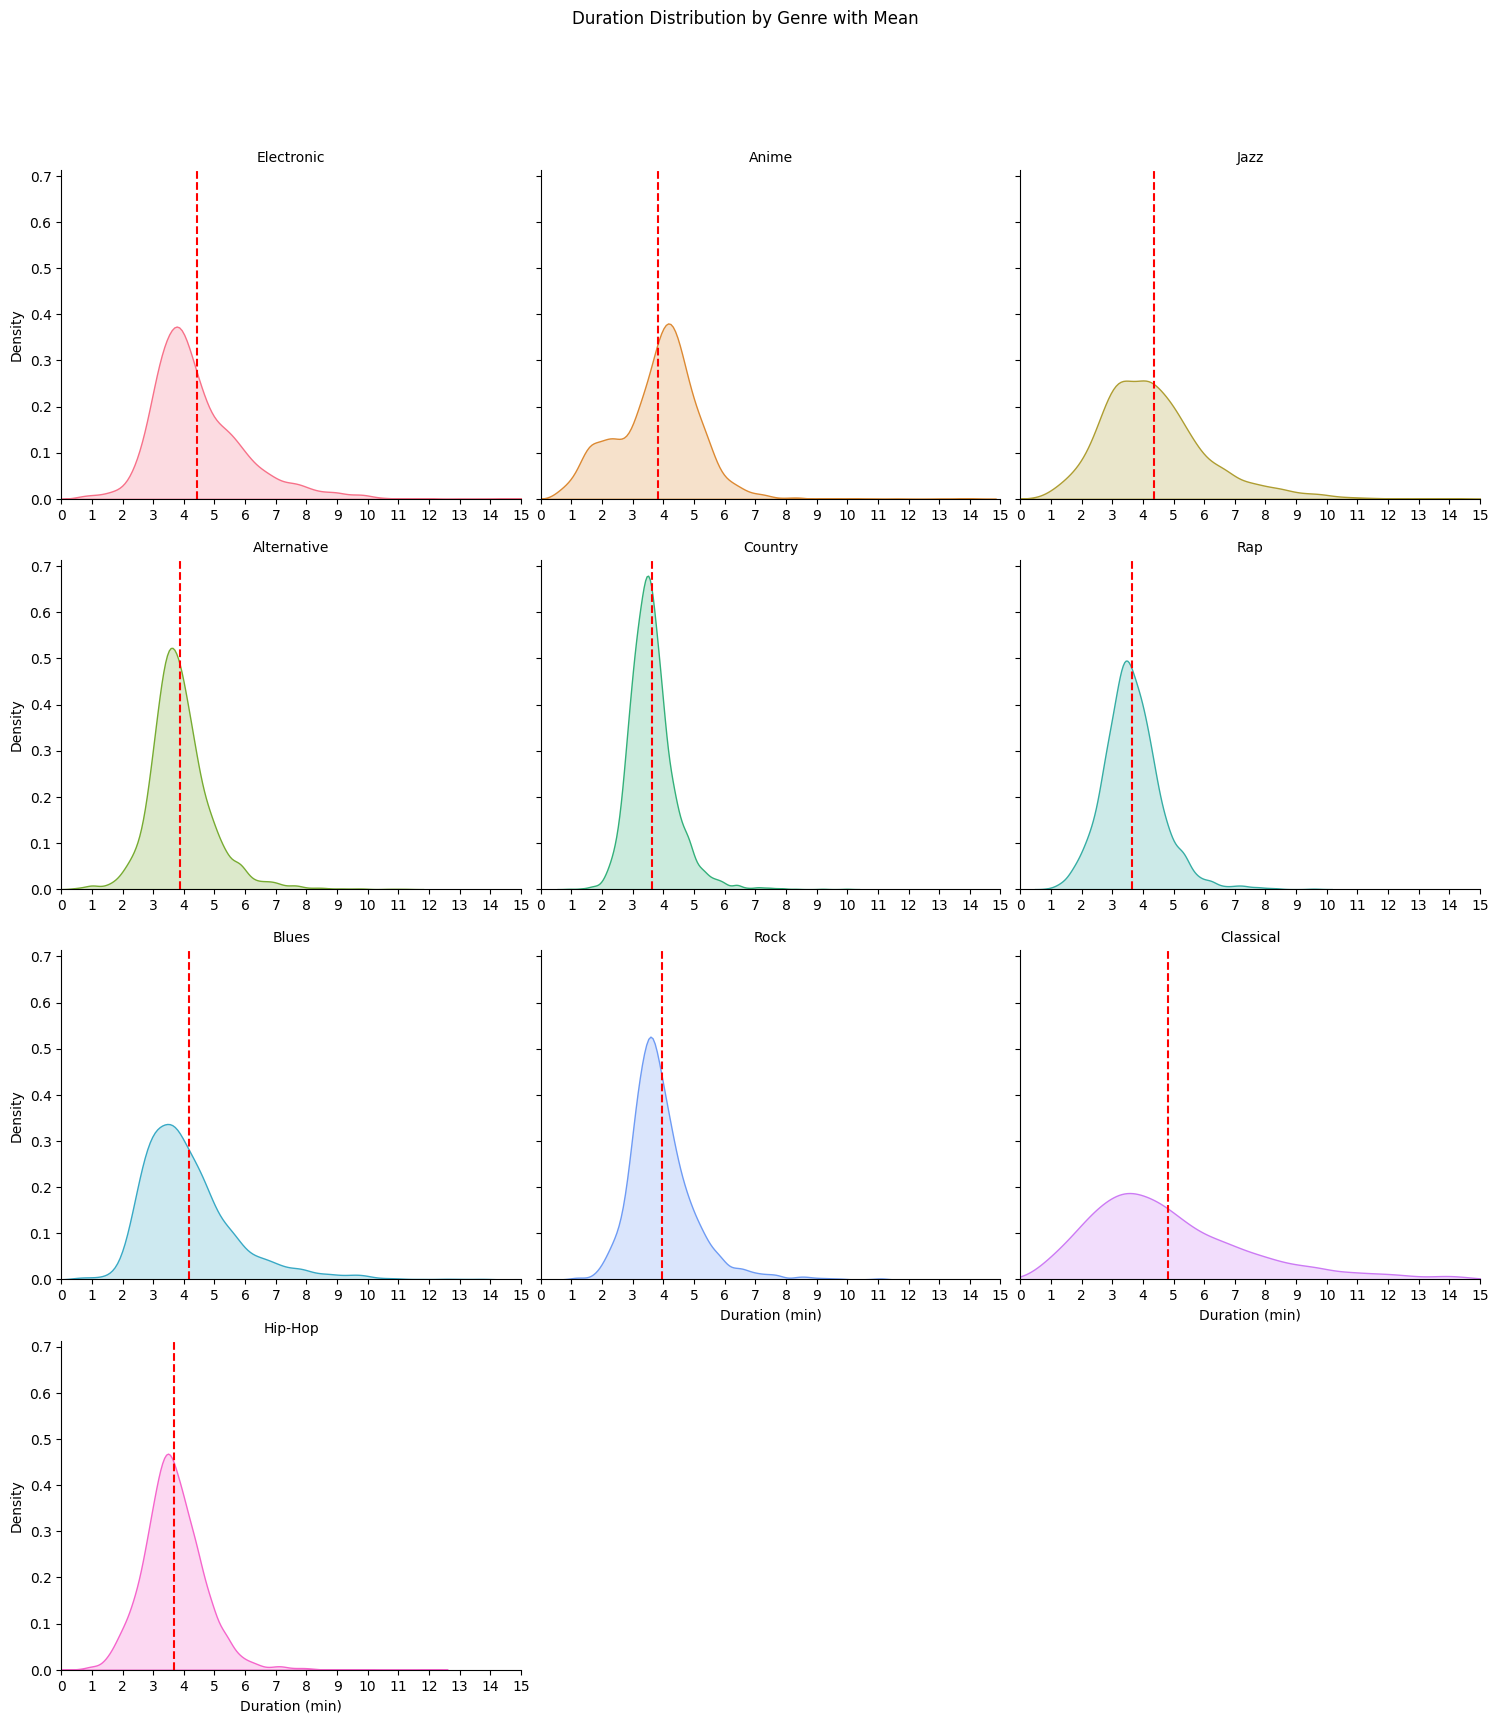

In [71]:
# Visualize the distribution of the duration column depending on the genre
g = sns.FacetGrid(duration_mins, col="music_genre", col_wrap=3, height=5, sharex=False, sharey=True, hue="music_genre", palette="husl")

def add_kde_with_mean(data, **kwargs):
    sns.kdeplot(data=data, x="duration_min", fill=True, **kwargs)
    plt.axvline(data["duration_min"].mean(), color='red', linestyle='--', label='Mean')
    
g.map_dataframe(add_kde_with_mean)

for ax in g.axes.flat:
  ax.set_xlim(0, 15)
  ax.set_xticks(range(0, 16, 1))
    
g.set_titles("{col_name}")
g.set_axis_labels("Duration (min)", "Density")
g.figure.suptitle('Duration Distribution by Genre with Mean')
plt.subplots_adjust(bottom=0.15, top=0.9) 

plt.show()

In [ ]:
# Visualize the distribution of the popularity column depending on the genre
g = sns.FacetGrid(music_df, col="music_genre", col_wrap=3, height=5, sharex=False, sharey=True, hue="music_genre", palette="husl")


def add_kde_with_mean(data, **kwargs):
    sns.kdeplot(data=data, x="popularity", fill=True, **kwargs)
    plt.axvline(data["popularity"].mean(), color='red', linestyle='--', label='Mean')  

g.map_dataframe(add_kde_with_mean)

for ax in g.axes.flat:
  ax.set_xticks(range(0, 110, 10)) 

g.set_titles("{col_name}")
g.set_axis_labels("Popularity", "Density")
plt.subplots_adjust(bottom=0.15, top=0.9) 
g.figure.suptitle('Popularity Distribution by Genre with Mean')
plt.show()

In [ ]:
# Visualize the distribution of the acousticness column depending on the genre
g = sns.FacetGrid(music_df, col="music_genre", col_wrap=3, height=5, sharex=False, sharey=True, hue="music_genre", palette="husl")


def add_kde_with_mean(data, **kwargs):
    sns.kdeplot(data=data, x="acousticness", fill=True, **kwargs)
    plt.axvline(data["acousticness"].mean(), color='red', linestyle='--', label='Mean')  

g.map_dataframe(add_kde_with_mean)

for ax in g.axes.flat:
  ax.set_xlim(0, 1)
  ax.set_xticks(np.arange(0, 1.1, 0.1))

g.set_titles("{col_name}")
g.set_axis_labels("Acousticness", "Density")
plt.subplots_adjust(bottom=0.15, top=0.9) 
g.figure.suptitle('Acousticness Distribution by Genre with Mean')
plt.show()

In [ ]:
# Visualize the distribution of the danceability column depending on the genre
g = sns.FacetGrid(music_df, col="music_genre", col_wrap=3, height=5, sharex=False, sharey=True, hue="music_genre", palette="husl")


def add_kde_with_mean(data, **kwargs):
    sns.kdeplot(data=data, x="danceability", fill=True, **kwargs)
    plt.axvline(data["danceability"].mean(), color='red', linestyle='--', label='Mean')  

g.map_dataframe(add_kde_with_mean)

for ax in g.axes.flat:
  ax.set_xlim(0, 1)
  ax.set_xticks(np.arange(0, 1.1, 0.1))

g.set_titles("{col_name}")
g.set_axis_labels("Danceability", "Density")
plt.subplots_adjust(bottom=0.15, top=0.9) 
g.figure.suptitle('Danceability Distribution by Genre with Mean')
plt.show()

In [ ]:
# Visualize the distribution of the energy column depending on the genre
g = sns.FacetGrid(music_df, col="music_genre", col_wrap=3, height=5, sharex=False, sharey=True, hue="music_genre", palette="husl")


def add_kde_with_mean(data, **kwargs):
    sns.kdeplot(data=data, x="energy", fill=True, **kwargs)
    plt.axvline(data["energy"].mean(), color='red', linestyle='--', label='Mean')  

g.map_dataframe(add_kde_with_mean)

for ax in g.axes.flat:
  ax.set_xlim(0, 1)
  ax.set_xticks(np.arange(0, 1.1, 0.1))

g.set_titles("{col_name}")
g.set_axis_labels("Energy", "Density")
plt.subplots_adjust(bottom=0.15, top=0.9) 
g.figure.suptitle('Energy Distribution by Genre with Mean')
plt.show()

In [ ]:
# Visualize the distribution of the instrumentalness column depending on the genre
g = sns.FacetGrid(music_df, col="music_genre", col_wrap=3, height=5, sharex=False, sharey=False, hue="music_genre", palette="husl")


def add_kde_with_mean(data, **kwargs):
    sns.kdeplot(data=data, x="instrumentalness", fill=True, **kwargs)
    plt.axvline(data["instrumentalness"].mean(), color='red', linestyle='--', label='Mean')  

g.map_dataframe(add_kde_with_mean)

for ax in g.axes.flat:
  ax.set_xlim(0, 1)
  ax.set_xticks(np.arange(0, 1.1, 0.1))

g.set_titles("{col_name}")
g.set_axis_labels("Instrumentalness", "Density")
plt.subplots_adjust(bottom=0.15, top=0.9) 
g.figure.suptitle('Instrumentalness Distribution by Genre with Mean')
plt.show()

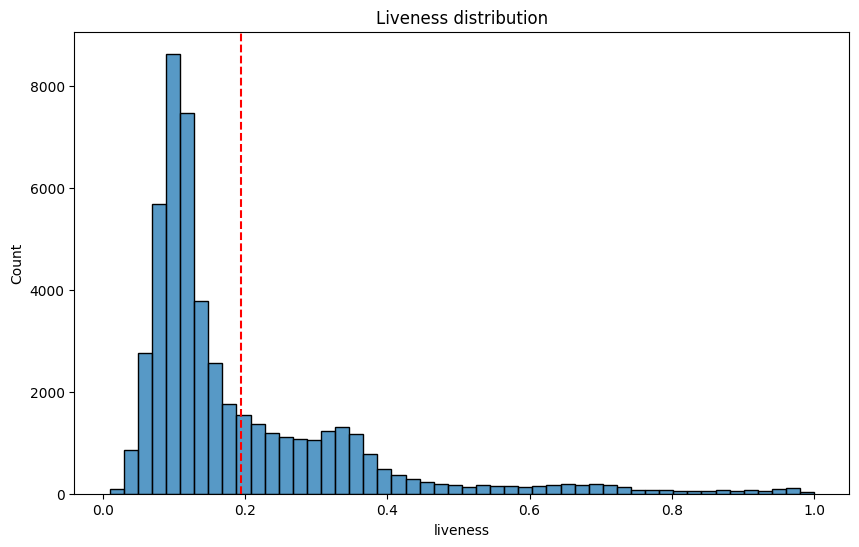

In [72]:
# Visualize the distribution of the liveness column

plt.figure(figsize=(10, 6))
sns.histplot(music_df['liveness'], bins=50)
plt.axvline(music_df['liveness'].mean(), color='red', linestyle='--', label='Mean')
plt.title('Liveness distribution')
plt.show()

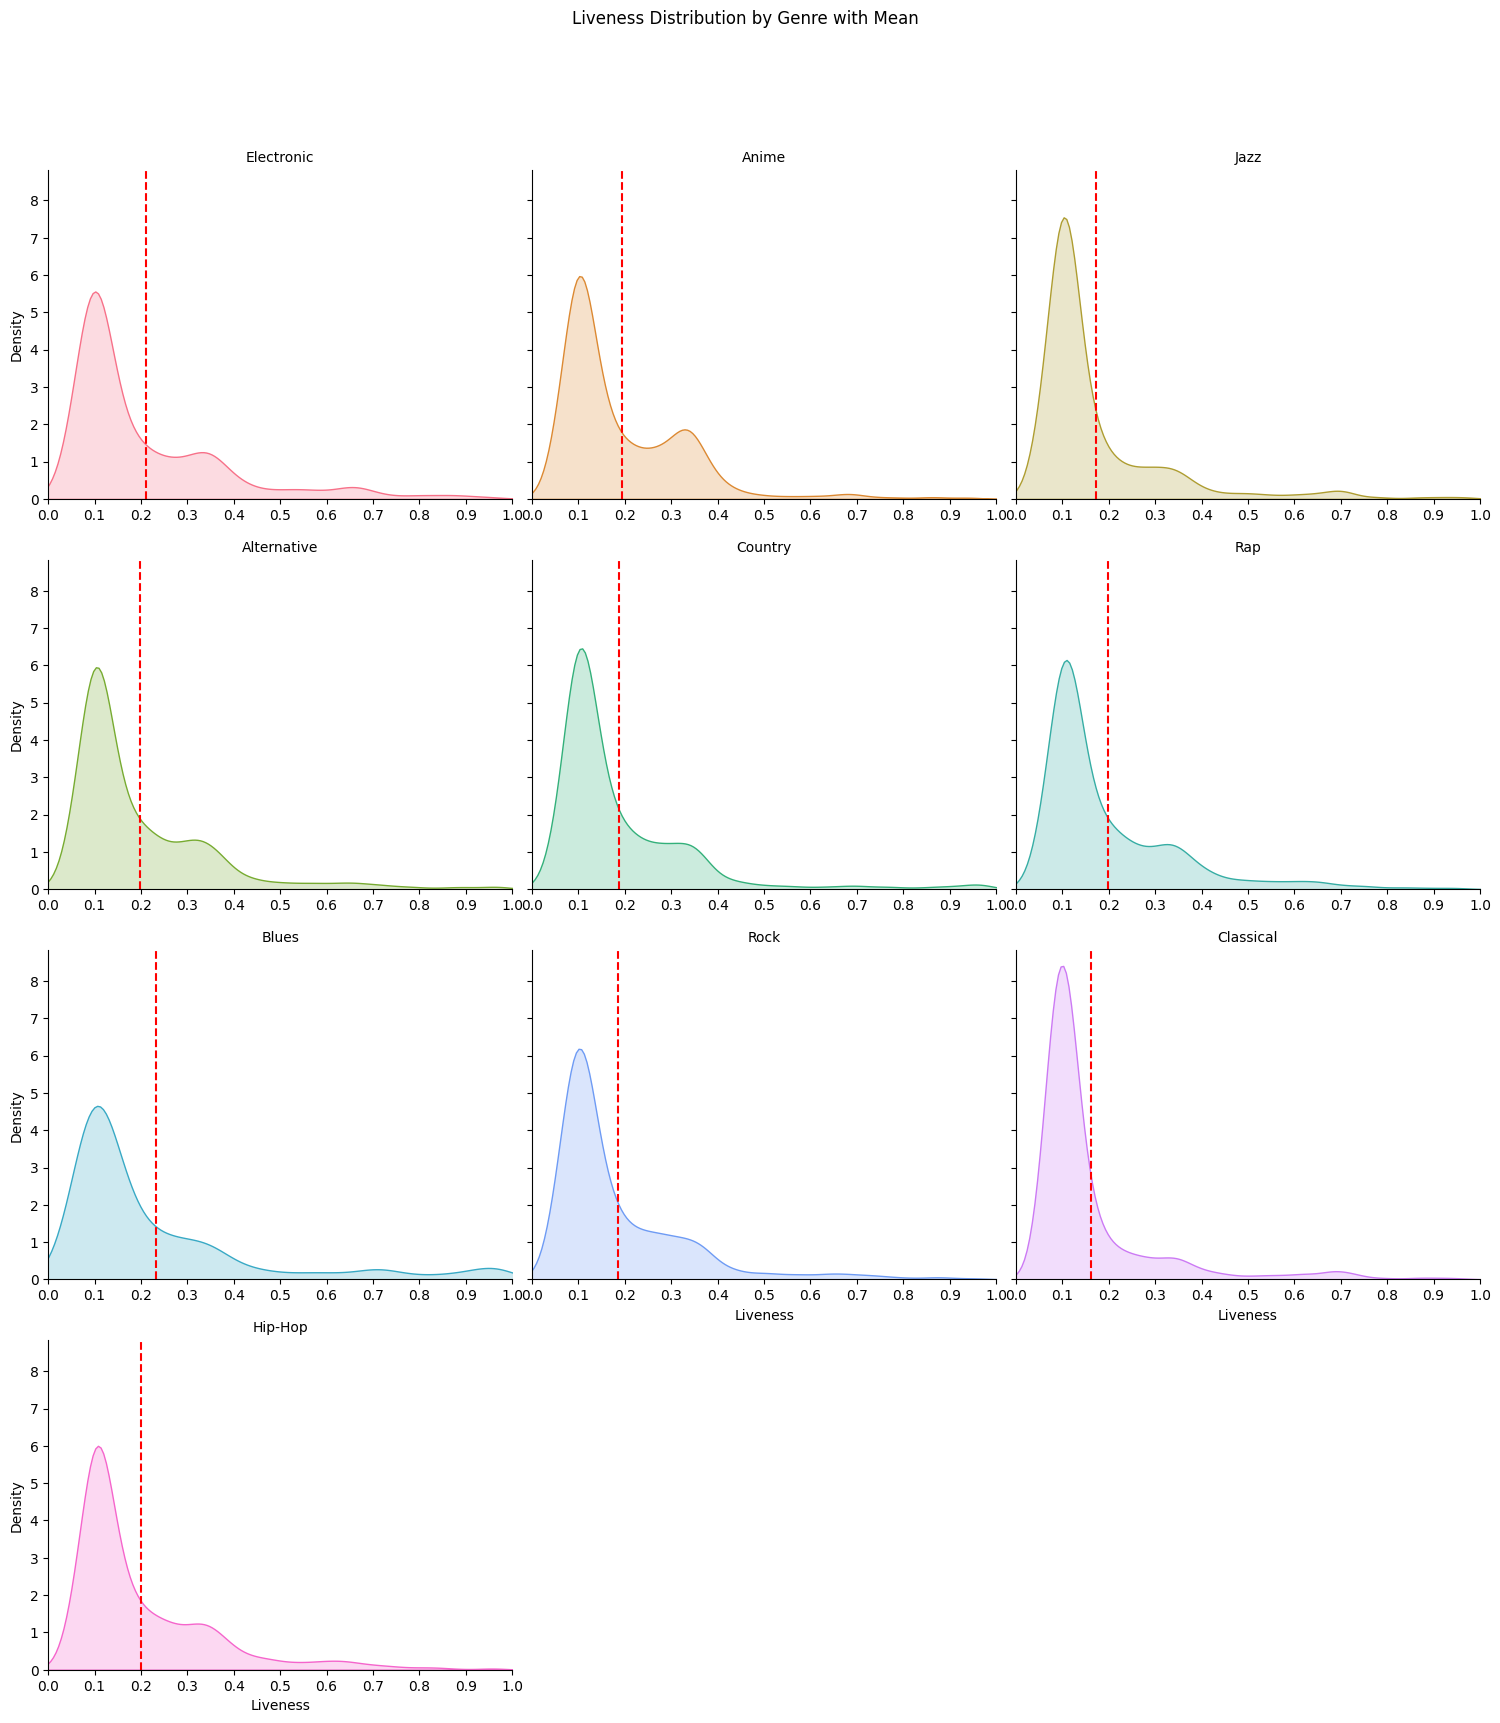

In [73]:
# Visualize the distribution of the liveness column depending on the genre
g = sns.FacetGrid(music_df, col="music_genre", col_wrap=3, height=5, sharex=False, sharey=True, hue="music_genre", palette="husl")

def add_kde_with_mean(data, **kwargs):
    sns.kdeplot(data=data, x="liveness", fill=True, **kwargs)
    plt.axvline(data["liveness"].mean(), color='red', linestyle='--', label='Mean')
  
g.map_dataframe(add_kde_with_mean)

for ax in g.axes.flat:
  ax.set_xlim(0, 1)
  ax.set_xticks(np.arange(0, 1.1, 0.1))
  
g.set_titles("{col_name}")

g.set_axis_labels("Liveness", "Density")
g.figure.suptitle('Liveness Distribution by Genre with Mean')
plt.subplots_adjust(bottom=0.15, top=0.9)

plt.show()

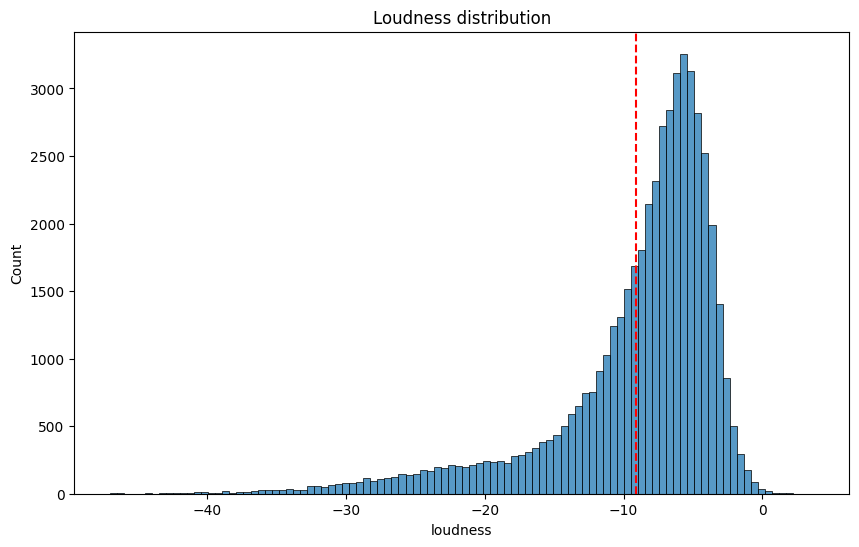

In [74]:
# Visualize the distribution of the loudness column
plt.figure(figsize=(10, 6))
sns.histplot(music_df['loudness'], bins=100)
plt.axvline(music_df['loudness'].mean(), color='red', linestyle='--', label='Mean')
plt.title('Loudness distribution')
plt.show()

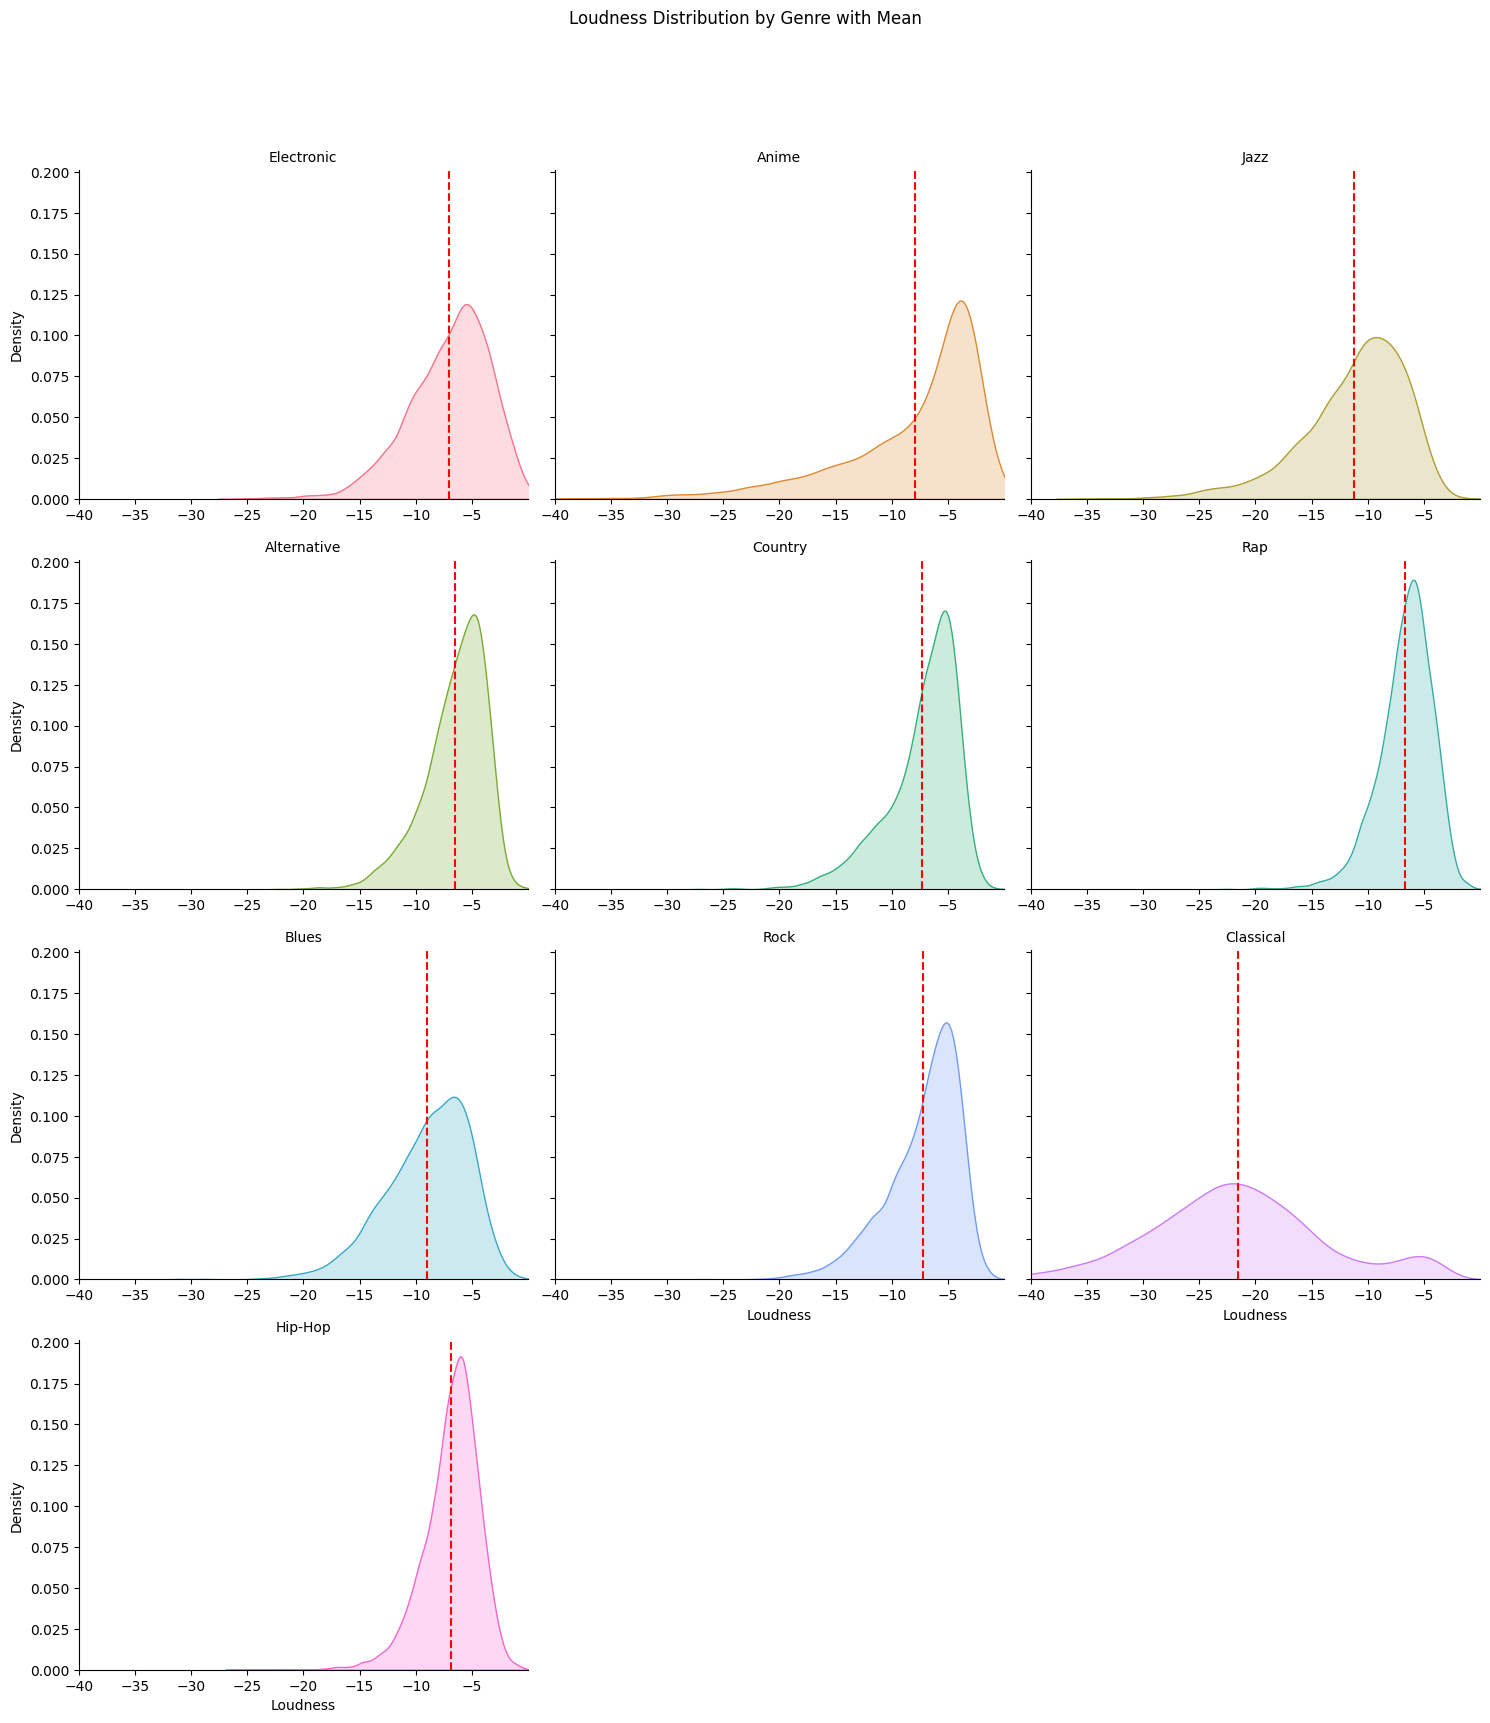

In [75]:
# Visualize the distribution of the loudness column depending on the genre
g = sns.FacetGrid(music_df, col="music_genre", col_wrap=3, height=5, sharex=False, sharey=True, hue="music_genre", palette="husl")

def add_kde_with_mean(data, **kwargs):
    sns.kdeplot(data=data, x="loudness", fill=True, **kwargs)
    plt.axvline(data["loudness"].mean(), color='red', linestyle='--', label='Mean')
    
g.map_dataframe(add_kde_with_mean)

for ax in g.axes.flat:
  ax.set_xlim(-40, 0)
  ax.set_xticks(range(-40, 0, 5))
  
g.set_titles("{col_name}")
g.set_axis_labels("Loudness", "Density")

g.figure.suptitle('Loudness Distribution by Genre with Mean')
plt.subplots_adjust(bottom=0.15, top=0.9)

plt.show()

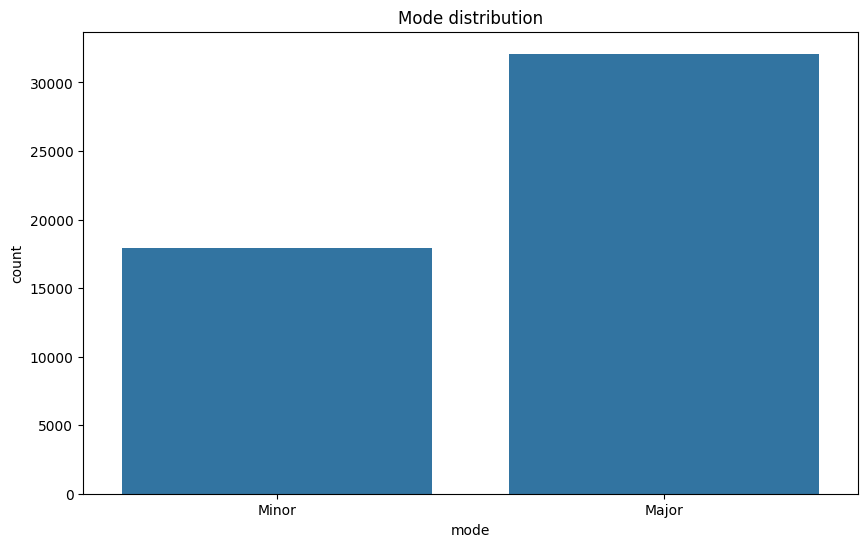

In [76]:
# Visualize the modes distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='mode', data=music_df)
plt.title('Mode distribution')
plt.show()

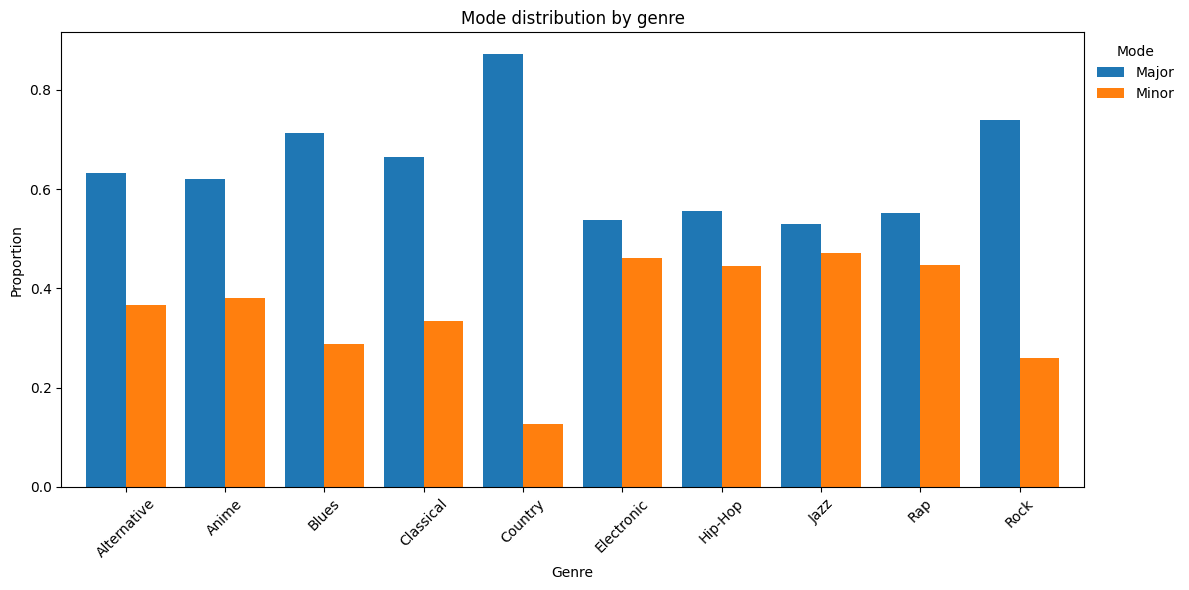

In [77]:
# Reformatear los datos para obtener un par de barras para cada género
mode_genre_distribution = music_df.groupby('music_genre')['mode'].value_counts(normalize=True).unstack()

# Crear el gráfico
mode_genre_distribution.plot(kind='bar', figsize=(12, 6), width=0.8)

# Personalizar el gráfico
plt.legend(title='Mode', bbox_to_anchor=(1, 1), loc='upper left', frameon=False)
plt.title('Mode distribution by genre')
plt.xlabel('Genre')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

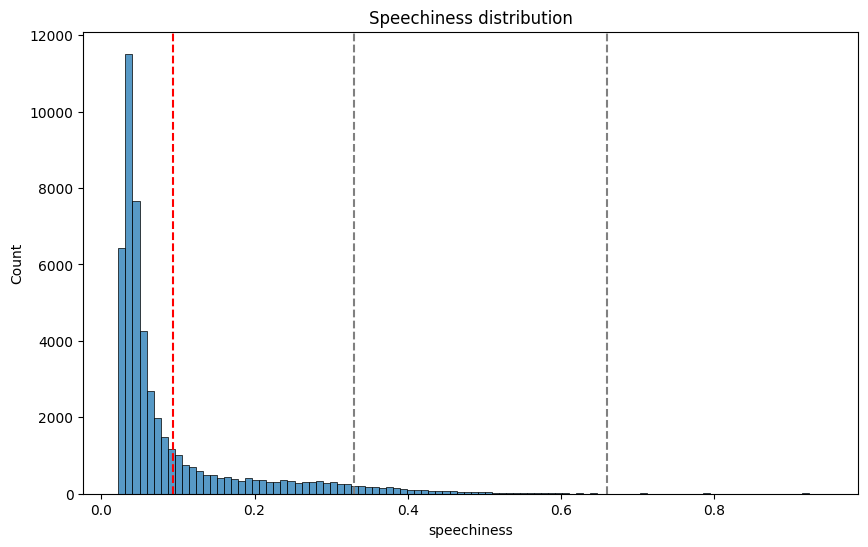

In [78]:
# Visualize the distribution of the speechiness column
plt.figure(figsize=(10, 6))
sns.histplot(music_df['speechiness'], bins=100)
plt.axvline(music_df['speechiness'].mean(), color='red', linestyle='--', label='Mean')
plt.axvline(0.33, color='grey', linestyle='--', label='.33')
plt.axvline(0.66, color='grey', linestyle='--', label='.66')
plt.title('Speechiness distribution')
plt.show()

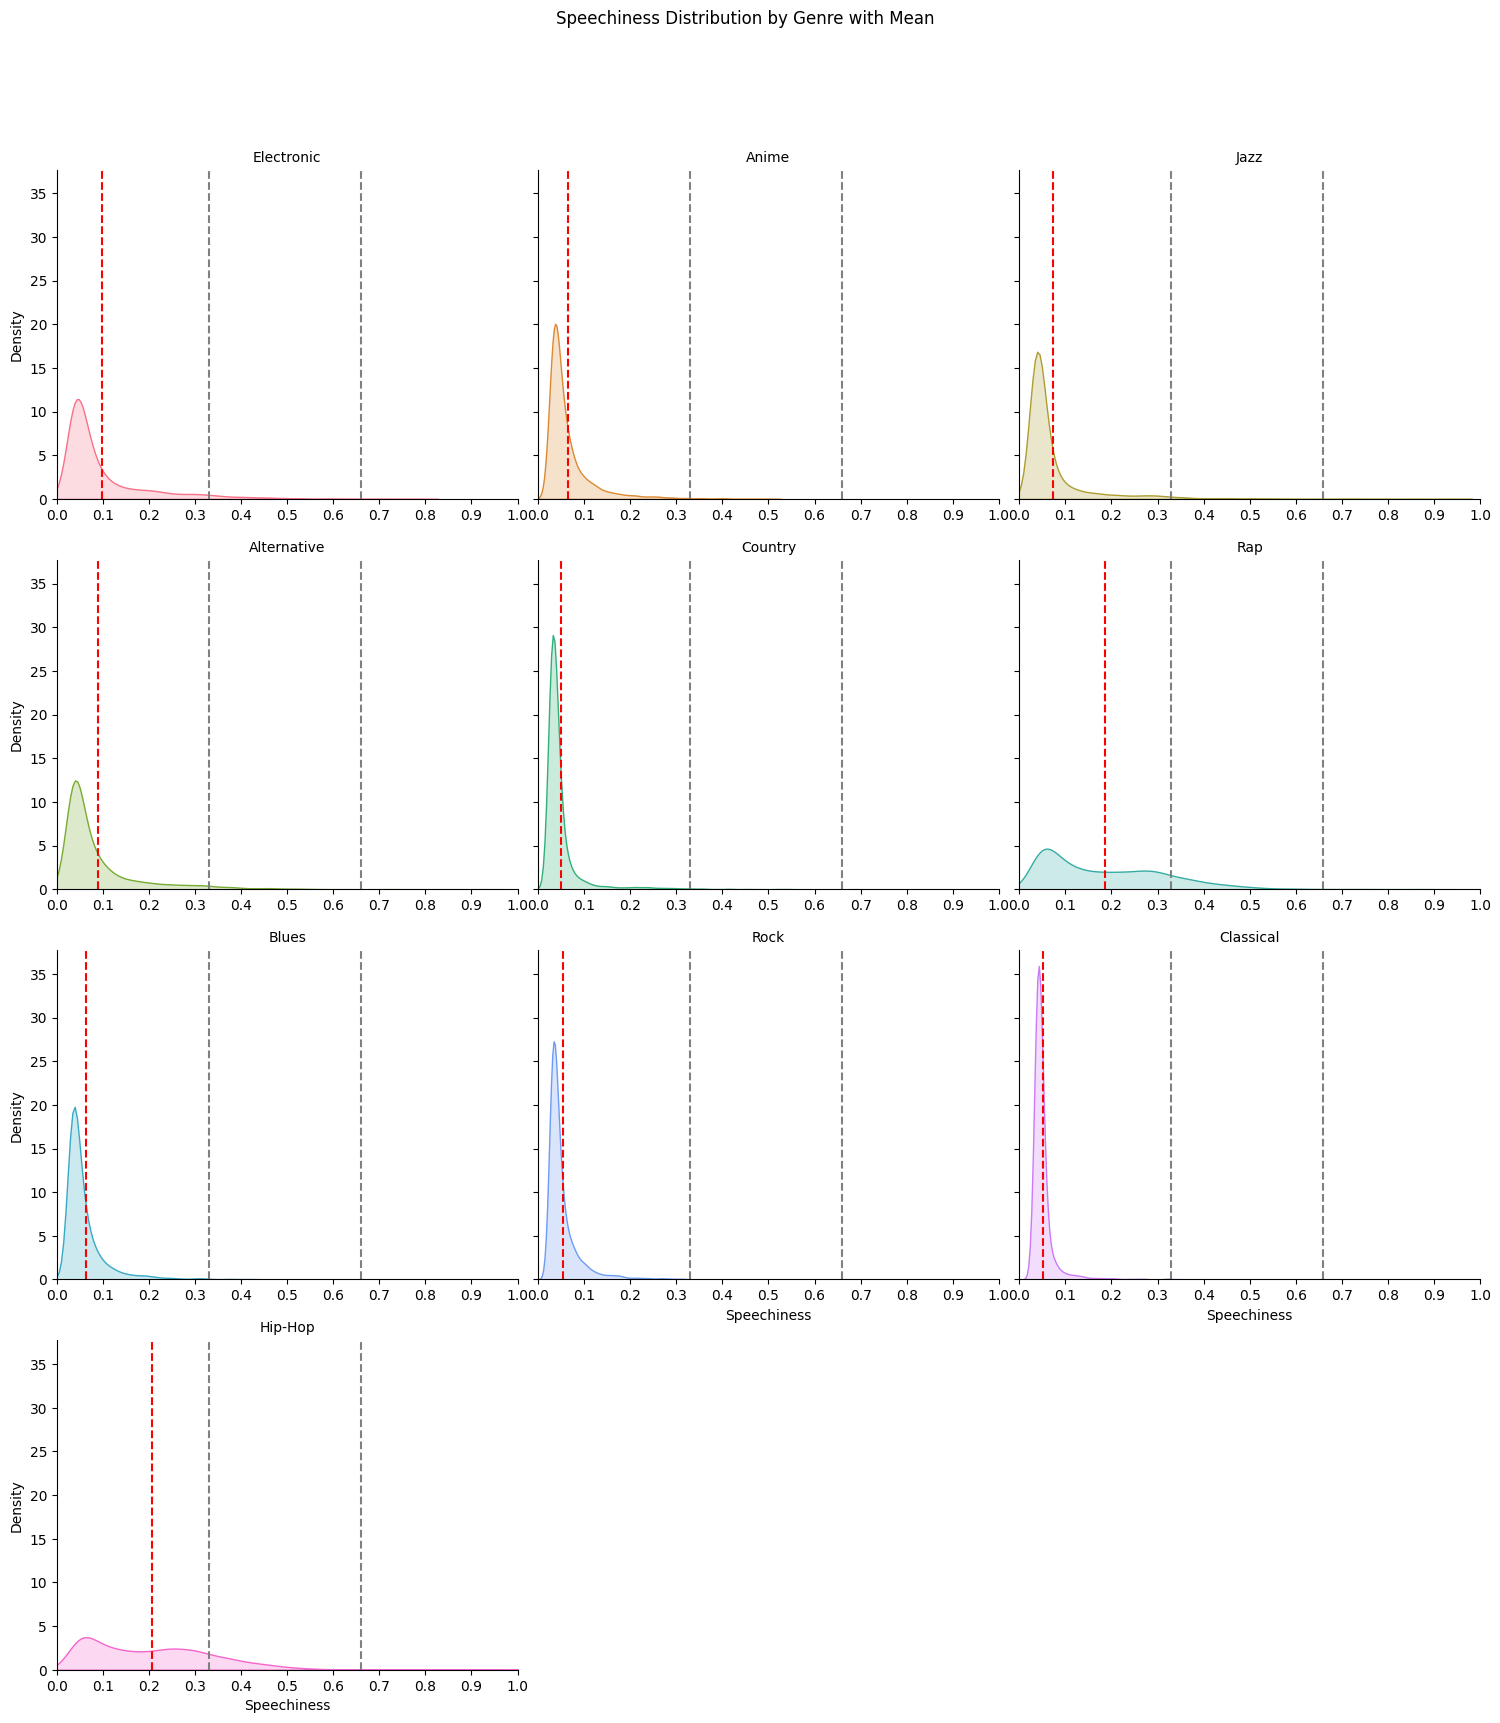

In [79]:
# Visualize the distribution of the speechiness column depending on the genre
g = sns.FacetGrid(music_df, col="music_genre", col_wrap=3, height=5, sharex=False, sharey=True, hue="music_genre", palette="husl")

def add_kde_with_mean(data, **kwargs):
    sns.kdeplot(data=data, x="speechiness", fill=True, **kwargs)
    plt.axvline(data["speechiness"].mean(), color='red', linestyle='--', label='Mean')
    plt.axvline(0.33, color='grey', linestyle='--', label='.33')
    plt.axvline(0.66, color='grey', linestyle='--', label='.66')
    
g.map_dataframe(add_kde_with_mean)

for ax in g.axes.flat:
  ax.set_xlim(0, 1)
  ax.set_xticks(np.arange(0, 1.1, 0.1))
  
g.set_titles("{col_name}")
g.set_axis_labels("Speechiness", "Density")
g.figure.suptitle('Speechiness Distribution by Genre with Mean')
plt.subplots_adjust(bottom=0.15, top=0.9)

plt.show()

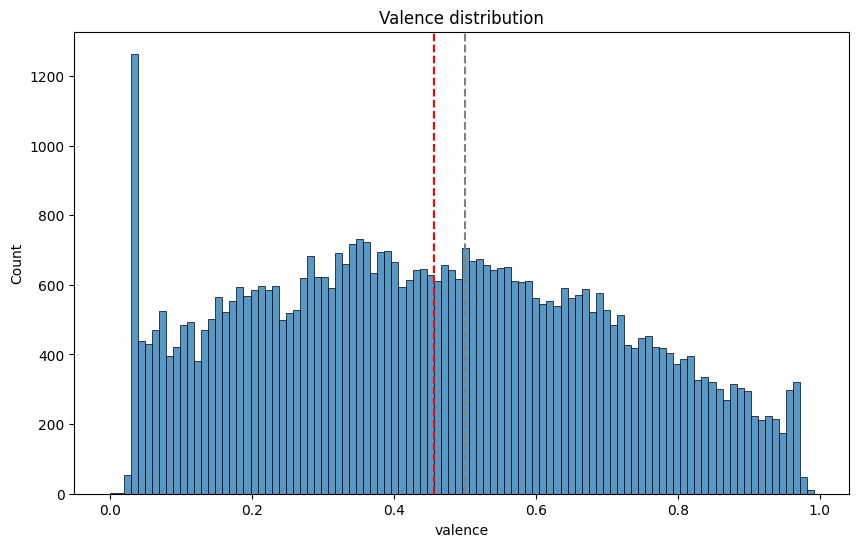

In [80]:
# Visualize the distribution of the valence column
plt.figure(figsize=(10, 6))
sns.histplot(music_df['valence'], bins=100)
plt.axvline(music_df['valence'].mean(), color='red', linestyle='--', label='Mean')
plt.axvline(0.5, color='grey', linestyle='--', label='.33')
plt.title('Valence distribution')
plt.show()

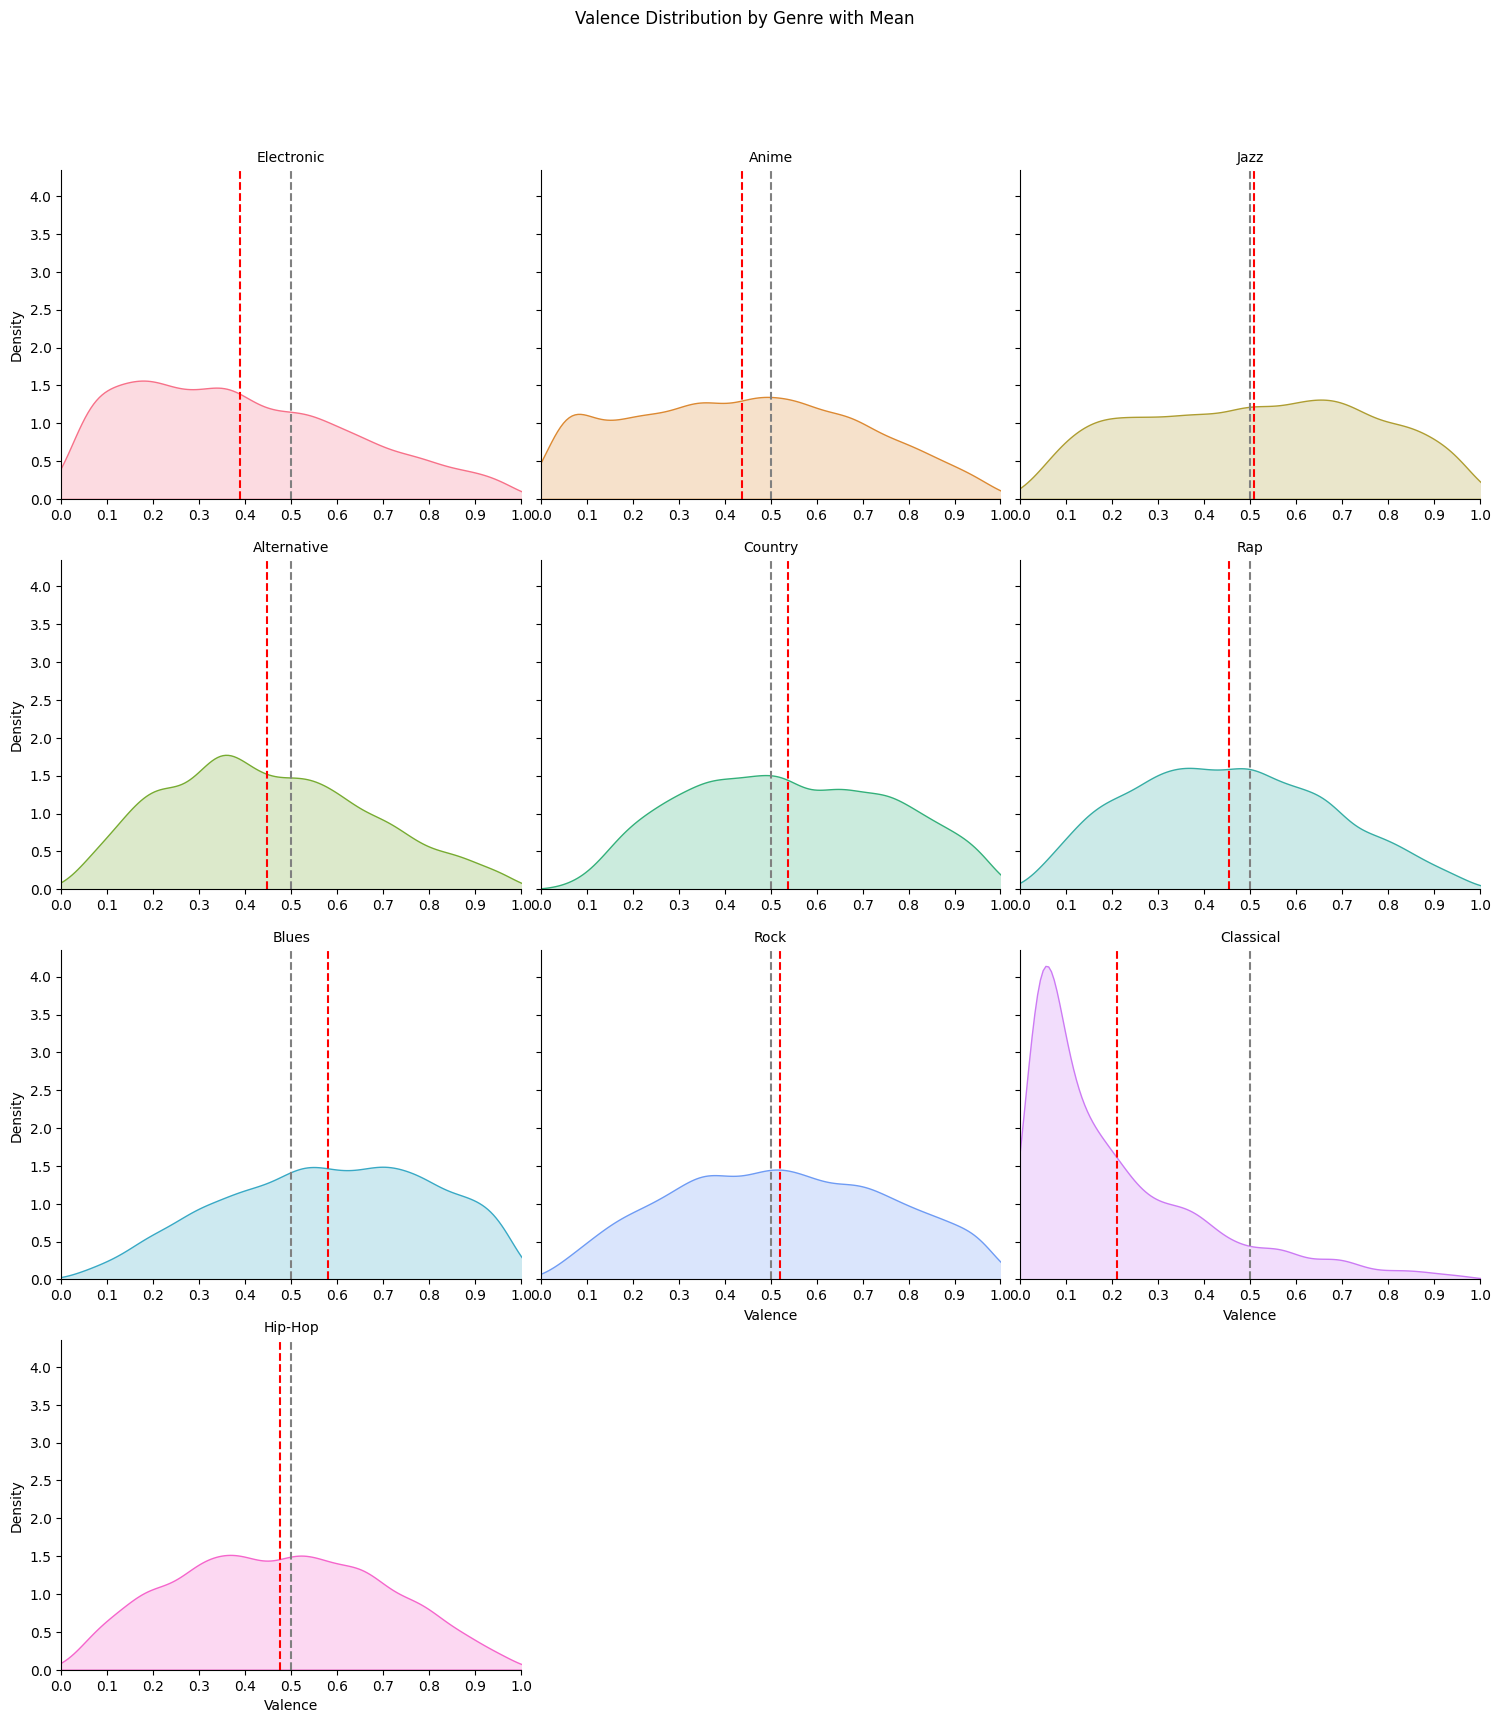

In [81]:
# Visualize the distribution of the valence column depending on the genre
g = sns.FacetGrid(music_df, col="music_genre", col_wrap=3, height=5, sharex=False, sharey=True, hue="music_genre", palette="husl")

def add_kde_with_mean(data, **kwargs):
    sns.kdeplot(data=data, x="valence", fill=True, **kwargs)
    plt.axvline(data["valence"].mean(), color='red', linestyle='--', label='Mean')
    plt.axvline(0.5, color='grey', linestyle='--', label='.33')

g.map_dataframe(add_kde_with_mean)

for ax in g.axes.flat:
  ax.set_xlim(0, 1)
  ax.set_xticks(np.arange(0, 1.1, 0.1))
  
g.set_titles("{col_name}")
g.set_axis_labels("Valence", "Density")
g.figure.suptitle('Valence Distribution by Genre with Mean')
plt.subplots_adjust(bottom=0.15, top=0.9)

plt.show()

In [82]:
# Are there duplicate songs in the dataset?
duplicates = music_df[music_df.duplicated(subset=['track_name', 'artist_name'], keep=False)].sort_values('track_name')
duplicates.to_csv('duplicate_song.csv', index=False)

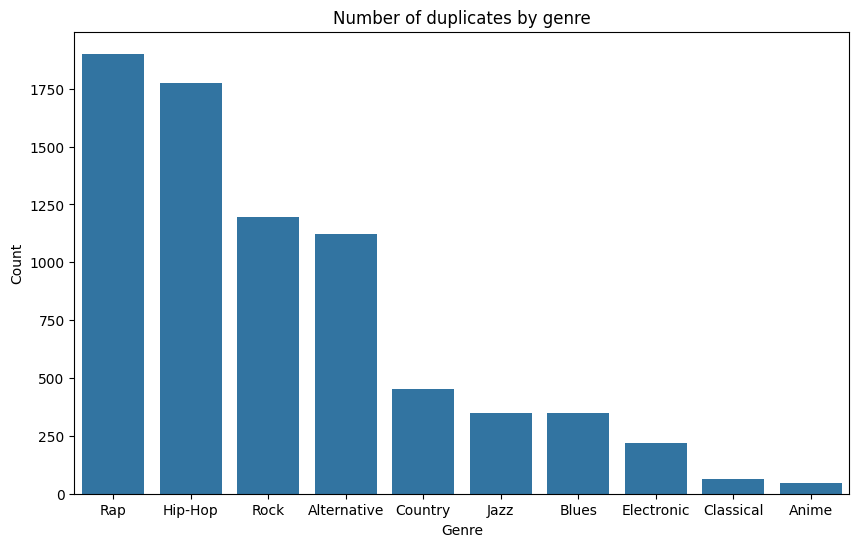

In [84]:
# Visualize number of duplicates by genre
duplicates_genre = duplicates['music_genre'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=duplicates_genre.index, y=duplicates_genre.values)
plt.title('Number of duplicates by genre')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()

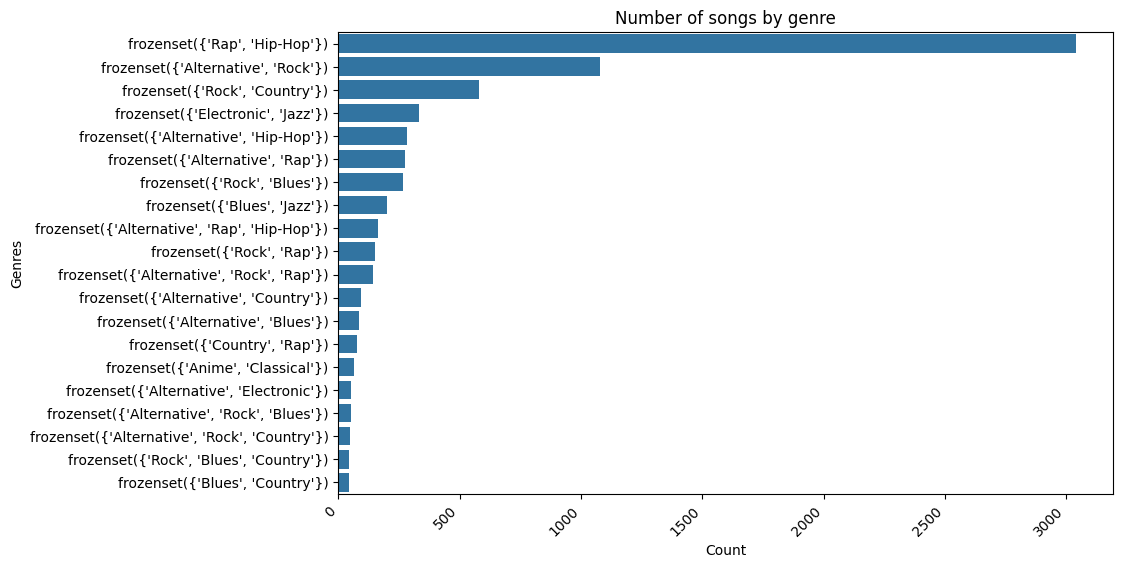

In [93]:
grouped_songs = duplicates.groupby(['track_name', 'artist_name'])

group_by_genres = {}
for name, group in grouped_songs:
  genre_set = frozenset(group['music_genre'])
  if genre_set not in group_by_genres:
    group_by_genres[genre_set] = group
  else:
    group_by_genres[genre_set] = pd.concat([group_by_genres[genre_set], group])

# Visualize number of songs by genre
songs_by_genres = {}
for key, value in group_by_genres.items():
  songs_by_genres[key] = len(value)
songs_by_genres = pd.Series(songs_by_genres).sort_values(ascending=False)
top_20_genres = songs_by_genres.head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_20_genres.values, y=top_20_genres.index)
plt.title('Number of songs by genre')
plt.xlabel('Count')
plt.ylabel('Genres')
plt.xticks(rotation=45, ha='right')
plt.show()